
# Student Enrollment

- In this example, we show how to reproduce the model of student
enrollment from Bergman et.al. (2020) with Gurobi Machine Learning.

- Data of students admissions in a college is used to
predict the probability that a student enrolls to the college.

- The data has 3 features: the SAT and GPA scores of each student, and the
scholarship (or merit) that was offered to each student. Finally, it is
known if each student decided to join the college or not.

- Based on this data a logistic regression is trained to predict the
probability that a student joins the college.

- The Admission Office has data for
SAT and GPA scores of the admitted students for the incoming class, and
they would want to offer scholarships to students with the goal of
maximizing the expected number of students that enroll in the college.
There is a total of $n$ students that are admitted. The maximal
budget for the sum of all scholarships offered is
$0.2 n \, \text{K\$}$ and each student can be offered a
scholarship of at most $2.5 \, \text{K\$}$.

- This problem can be expressed as a mathematical optimization problem as
follows. 
   -  Two vectors of decision variables $x$ and $y$ of
   dimension $n$ are used to model respectively the scholarship
   offered to each student in $\text{K\$}$ and the probability that
   they join. Denoting by $g$ the prediction function for the
   probability of the logistic regression we then have for each student
   $i$: $y_i = g(x_i, SAT_i, GPA_i)$

   - with $SAT_i$ and $GPA_i$ the (known) SAT and GPA score of each student.

   - The objective is to maximize the sum of the $y$ variables and the budget constraint imposes that the sum of the variables $x$ is less or equal to $0.2n$. Also, each variable $x_i$ is between 0 and 2.5.

   -  The full model then reads:
      \begin{align}\begin{aligned} &\max \sum_{i=1}^n y_i \\
         &\text{subject to:}\\
         &\sum_{i=1}^n x_i \le 0.2*n,\\
         &y_i = g(x_i, SAT_i, GPA_i) & & i = 1, \ldots, n,\\
         & 0 \le x_i \le 2.5 \quad \forall i=1...n  \end{aligned}\end{align} 

In this example differently to Bergman et.al. (2020) we scale
the features for the regression. Also, to fit in Gurobi’s limited size
license we only consider the problem where $n=250$.


## Load the Packages and the Datasets
We import the necessary packages. Besides the usual (``numpy``,
``gurobipy``, ``pandas``), for this we will use Scikit-learn’s Pipeline,
StandardScaler and LogisticRegression.


In [1]:
import gurobipy as gp
import gurobipy_pandas as gppd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

from gurobi_ml import add_predictor_constr

We now retrieve the historical data used to build the regression from
Janos repository.

The features we use for the regression are ``"merit"`` (scholarship),
``"SAT"`` and ``"GPA"`` and the target is ``"enroll"``. We store those
values.




In [38]:
# Base URL for retrieving data
janos_data_url = "https://raw.githubusercontent.com/INFORMSJoC/2020.1023/master/data/"
historical_data = pd.read_csv(
    janos_data_url + "college_student_enroll-s1-1.csv", index_col=0
)

# classify our features between the ones that are fixed and the ones that will be
# part of the optimization problem
features = ["merit", "SAT", "GPA"]
target = "enroll"

## Part I: Read and explore the data

In [39]:
historical_data.head()

,StudentID,SAT,GPA,merit,enroll
1,1,1507,3.72,1.64,0
2,2,1532,3.93,0.52,0
3,3,1487,3.77,1.67,0
4,4,1259,3.05,1.21,1
5,5,1354,3.39,1.65,1


### Features distribution per enrollment (1 enrolled, 0 not enrolled )

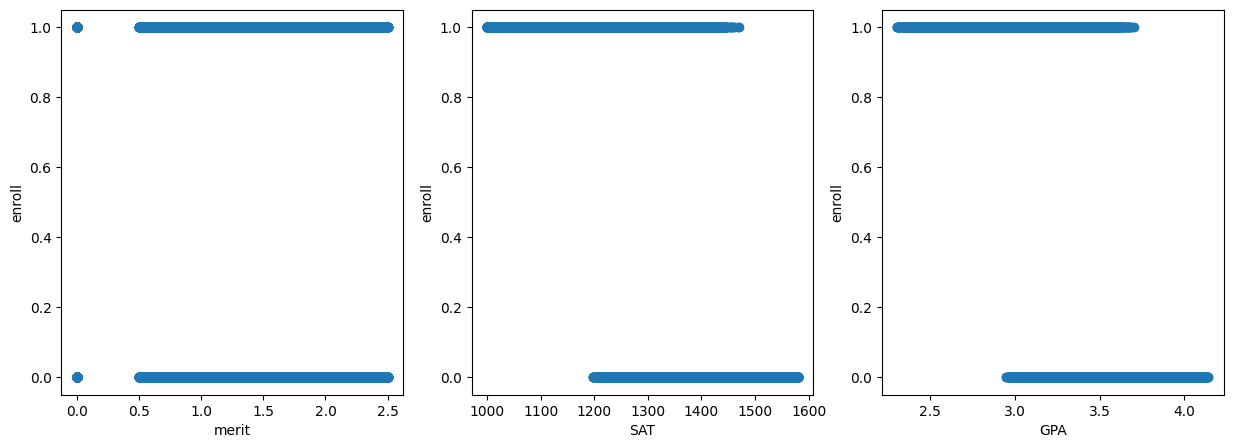

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(features):
    ax[i].scatter(historical_data[feature], historical_data[target])
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel(target)

plt.show();

### Overall frequency distribution of merit, SAT and GPA

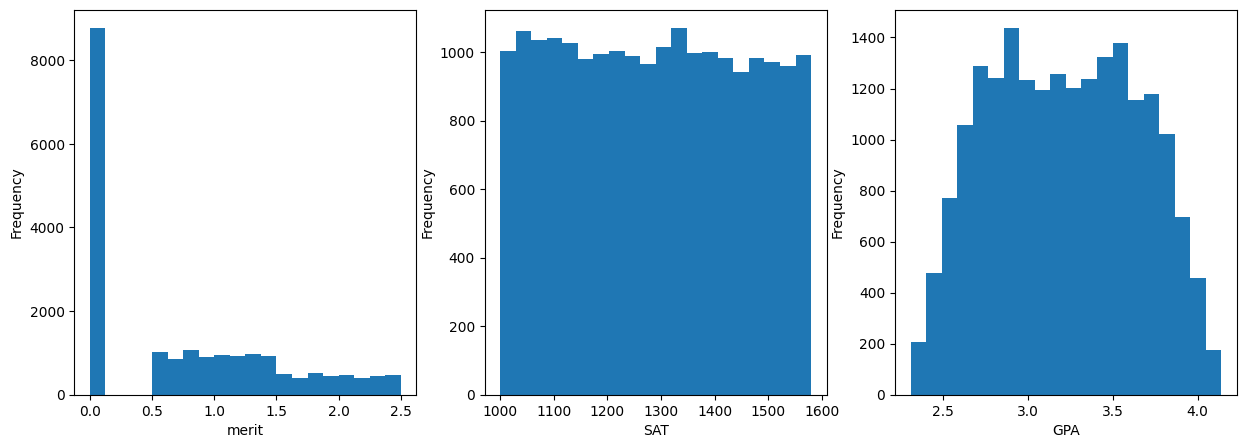

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, feature in enumerate(features):
    ax[i].hist(historical_data[feature], bins=20)
    ax[i].set_xlabel(feature)
    ax[i].set_ylabel("Frequency")

## PART II: Fit the logistic regression on the historical data

For the regression, we use a pipeline with a standard scaler and a
logistic regression. We build it using the ``make_pipeline`` from
``scikit-learn``.




In [42]:
# Run our regression
scaler = StandardScaler()
regression = LogisticRegression(random_state=1)
pipe = make_pipeline(scaler, regression)
pipe.fit(X=historical_data.loc[:, features], y=historical_data.loc[:, target])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(random_state=1))])

# PART III: Optimization Model

We now turn to building the mathematical optimization model for Gurobi.

First, retrieve the data for the new students. We won’t use all the data
there, we randomly pick 25 students from it.




In [43]:
# Retrieve new data used to build the optimization problem
studentsdata = pd.read_csv(janos_data_url + "college_applications6000.csv", index_col=0)

nstudents = 25

# Select randomly nstudents in the data
studentsdata = studentsdata.sample(nstudents, random_state=1)

In [44]:
studentsdata.head()

,SAT,GPA
StudentID,,
1484,1512,3.61
2186,1148,3.06
2521,1090,2.76
3722,1044,2.55
3728,1424,3.64


We can now create the our model:


In [51]:
# Initialize the optimization model
m = gp.Model()

The **y** decision variables are modeling the **probability of enrollment of each student**. They are indexed by students data. 

$y_i$

In [52]:
y = gppd.add_vars(m, studentsdata, name="enroll_probability")

 Next:
 
 - We want to complete studentsdata with a column of decision variables to **model the "merit" feature** . 
 
 - Those variable are between 0 and 2.5. 
    - $2.5\le x_i \le 2.5 \quad \forall i =1...n  $
 
 - They are added using the gppd extension and the resulting dataframe is stored in students_opt_data.

In [54]:
students_opt_data = studentsdata.gppd.add_vars(m, lb=0.0, ub=2.5, name="merit")

# We denote by x the (variable) "merit" feature
x = students_opt_data.loc[:, "merit"]

# Make sure that studentsdata contains only the features column and in the right order
students_opt_data = students_opt_data.loc[:, features]

m.update()

# Let's look at our features dataframe for the optimization
students_opt_data[:10]

,merit,SAT,GPA
StudentID,,,
1484,<gurobi.Var merit[1484]>,1512,3.61
2186,<gurobi.Var merit[2186]>,1148,3.06
2521,<gurobi.Var merit[2521]>,1090,2.76
3722,<gurobi.Var merit[3722]>,1044,2.55
3728,<gurobi.Var merit[3728]>,1424,3.64
4525,<gurobi.Var merit[4525]>,1040,2.44
235,<gurobi.Var merit[235]>,1030,2.61
4736,<gurobi.Var merit[4736]>,1399,3.42
5840,<gurobi.Var merit[5840]>,1090,2.54


We add the objective and the budget: $\max \sum_{i=1}^n y_i$

In [55]:
m.setObjective(y.sum(), gp.GRB.MAXIMIZE)
m.update()

**Budget constraint:**

$\sum_{i=1}^n x_i \le 0.2*n$

In [56]:

m.addConstr(x.sum() <= 0.2 * nstudents)
m.update()

**Regression constraints**

Finally, we insert the constraints from the regression. In this model we
want to have use the probability estimate of a student joining the
college, so we choose the parameter ``output_type`` to be
``"probability_1"``. Note that due to the shapes of the ``studentsdata``
data frame and ``y``, this will insert one regression constraint for
each student.

With the ``print_stats`` function we display what was added to the
model.

$y_i = g(x_i, SAT_i, GPA_i) \quad \forall i = 1, \ldots, n$




In [47]:
pred_constr = add_predictor_constr(
    m, pipe, students_opt_data, y, output_type="probability_1"
)

pred_constr.print_stats()

Model for pipe:
150 variables
100 constraints
25 general constraints
Input has shape (25, 3)
Output has shape (25, 1)

Pipeline has 2 steps:

--------------------------------------------------------------------------------
Step            Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
std_scaler           (25, 3)          125           75            0            0

log_reg              (25, 1)           25           25            0           25

--------------------------------------------------------------------------------


We can now optimize the problem. With Gurobi ≥ 11.0, the attribute
``FuncNonLinear`` is automatically set to 1 by Gurobi machine learning
on the nonlinear constraints it adds in order to deal algorithmically
with the logistic function. Older versions of Gurobi would make a piece-wise linear approximation of
the logistic function. 




In [48]:
m.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[x86] - Darwin 23.4.0 23E224)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 101 rows, 200 columns and 275 nonzeros
Model fingerprint: 0xe34d8bff
Model has 25 general constraints
Variable types: 200 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-01, 2e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [2e+00, 2e+03]
  RHS range        [7e-01, 1e+03]
Presolve removed 100 rows and 162 columns
Presolve time: 0.00s
Presolved: 132 rows, 39 columns, 291 nonzeros
Presolved model has 19 nonlinear constraint(s)

Solving non-convex MINLP

Variable types: 39 continuous, 0 integer (0 binary)
Found heuristic solution: objective 13.7903088

Root relaxation: objective 1.385440e+01, 12 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 E

We print the error:




In [49]:
print(
    "Maximum error in approximating the regression {:.6}".format(
        np.max(pred_constr.get_error())
    )
)

Maximum error in approximating the regression 3.74643e-09


Finally, note that we can directly get the input values for the
regression:




In [50]:
pred_constr.input_values

,merit,SAT,GPA
StudentID,,,
1484,3.597305e-07,1512.0,3.61
2186,7.387056e-07,1148.0,3.06
2521,0.000000e+00,1090.0,2.76
3722,0.000000e+00,1044.0,2.55
3728,3.597305e-07,1424.0,3.64
4525,0.000000e+00,1040.0,2.44
235,0.000000e+00,1030.0,2.61
4736,3.597469e-07,1399.0,3.42
5840,0.000000e+00,1090.0,2.54
